In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [48]:
import numpy as np
import re
from numpy import linalg as LA
from time import time
from scipy import sparse
import matplotlib.pyplot as plt

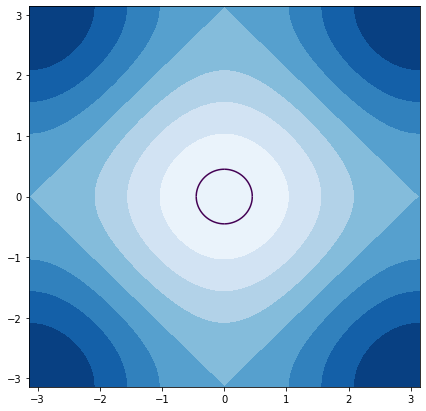

In [50]:
N=100
kx=np.linspace(0,np.pi,N)
ky=np.linspace(0,np.pi,N)
plt.rcParams['figure.figsize'] = [7,7]
Kx,Ky=np.meshgrid(kx,ky)
E=-2*(np.cos(Kx)+np.cos(Ky))
E_F=-3.8
CS=plt.contour(kx,ky,E,levels=[E_F],color='red')
plt.contour(-kx,ky,E,levels=[E_F],color='red')
plt.contour(-kx,-ky,E,levels=[E_F],color='red')
plt.contour(kx,-ky,E,levels=[E_F],color='red')
plt.contourf(kx,ky,E,cmap='Blues')
plt.contourf(-kx,ky,E,cmap='Blues')
plt.contourf(-kx,-ky,E,cmap='Blues')
plt.contourf(kx,-ky,E,cmap='Blues')
F = CS.collections[0].get_paths()[0]
coordsF = F.vertices
vF = np.dstack([2*np.sin(coordsF[:,0]),2*np.sin(coordsF[:,1])])[0]
vFmag = vF[:,0]*vF[:,0]+vF[:,1]*vF[:,1]
shatF  = vF/np.transpose([vFmag])
thetaF0 =  np.float64(np.arctan((vF[:,1]+1e-2)/(vF[:,0]+1e-2))) 
coordsFx_irr = coordsF[:,0]
coordsFy_irr = coordsF[:,1]
Lambda0=np.pi/(2*np.sqrt(2))
steps=30000 #30000
eps=(1-1/(N*N)) #0.9999
lambdaF=Lambda0*eps**np.linspace(0,steps-1,steps)
ThetaF,LambdaF=np.meshgrid(thetaF0,lambdaF)
Fwvfx_out = coordsFx_irr+LambdaF*np.cos(ThetaF)
Fwvfy_out = coordsFy_irr+LambdaF*np.sin(ThetaF)
EFwvf=-2*(np.cos(Fwvfx_out)+np.cos(Fwvfy_out))

In [52]:
EFwvfAvg=np.sum(EFwvf,axis=1)/len(thetaF0)

In [54]:
EFwvfAvg

array([-1.90793625, -1.9081885 , -1.90844072, ..., -3.7488182 ,
       -3.74882362, -3.74882903])

In [56]:
J0=1/(N*N)#1.19e9/(N*N)#5e-3/(N*N)
J=np.zeros(steps)
J[0]=J0
omega=4 #1/2 of bandwidth in 2D

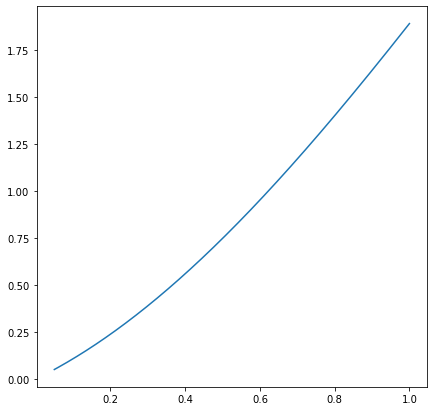

In [58]:
plt.plot(lambdaF/Lambda0,EFwvfAvg-E_F)

In [60]:
k=0
for i in range(len(lambdaF)-1):
    Ek=EFwvfAvg[i]-E_F
    if(Ek-J[0]/4>0):
        if(Ek-J[i]/4>0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    else:
        if(Ek-J[i]/4<0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    

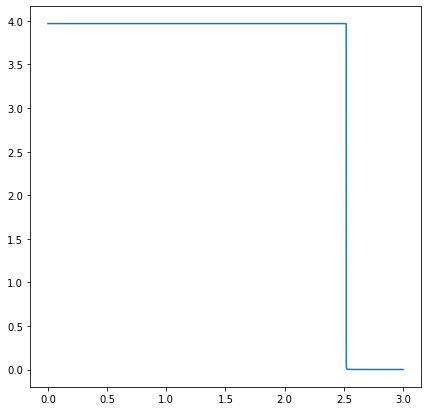

In [62]:
plt.plot(-np.log(lambdaF/Lambda0),J[::-1])

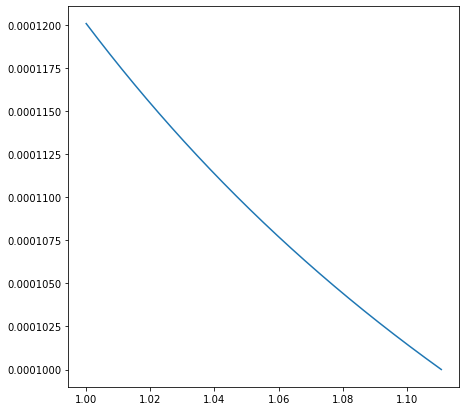

In [64]:
figure,ax=plt.subplots(1)
ax.plot(lambdaF[0:1051],J[0:1051])

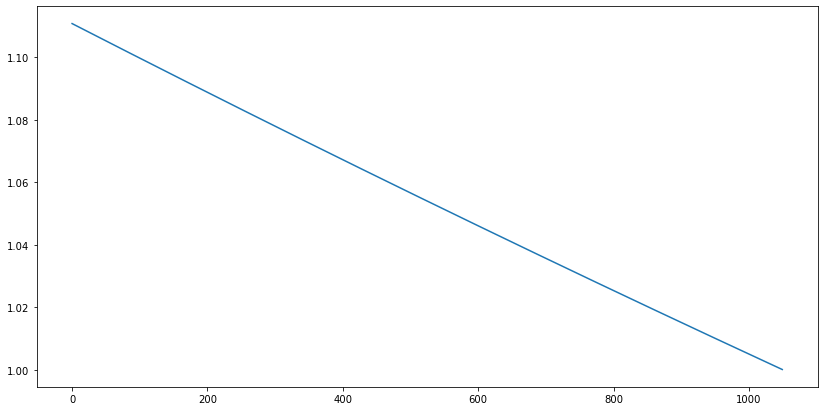

In [66]:
plt.plot(lambdaF[0:1050])

## $Regime-1: J_{0}= 5\times 10^{-3}t$ to $7\times 10^{-3}t$

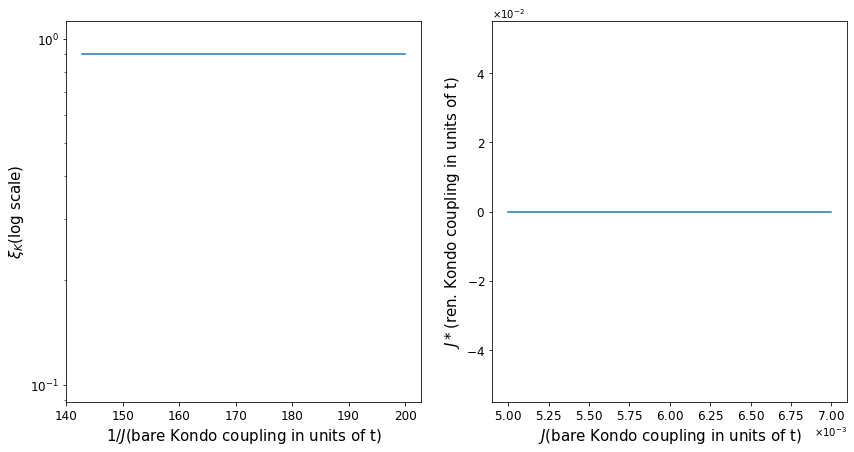

In [68]:
J0arr=np.linspace(5e-3,7e-3,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr*N*N,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime1.png')

## $Regime-2: J_{0}= 7\times 10^{-3}t$ to $t$

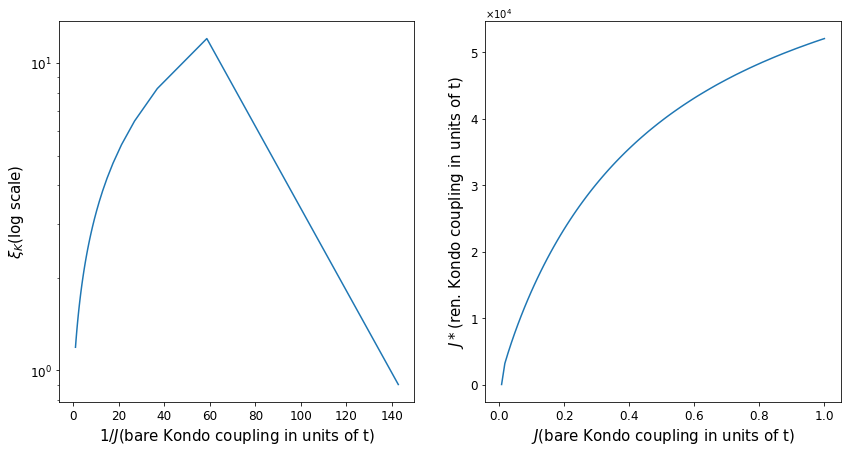

In [70]:
J0arr=np.linspace(7e-3,1,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr*N*N,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime2.svg')

## $Regime-3: J_{0}= t$ to $10t$

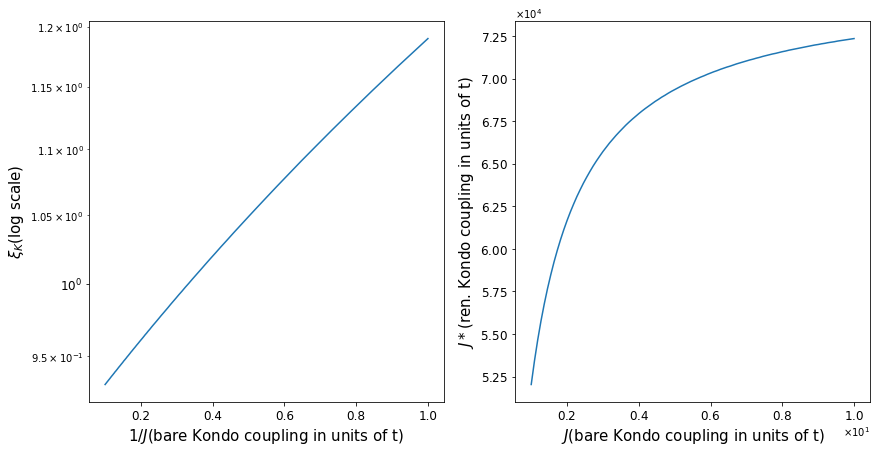

In [72]:
J0arr=np.linspace(1,10,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            
#J0arr=np.linspace(7e-3,1,100)
figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr*N*N,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime3.svg')

In [74]:
np.linspace(0,6,7)

array([0., 1., 2., 3., 4., 5., 6.])

In [76]:
4.9*10**(-3)*1.02656**820

10601154.997503908

In [78]:
np.zeros([7,len(J0arr)])[:,0]

array([0., 0., 0., 0., 0., 0., 0.])

In [80]:
4.9e-3*(1.02656)**np.linspace(50,600,600)

array([1.81724288e-02, 1.86151286e-02, 1.90686131e-02, 1.95331449e-02,
       2.00089932e-02, 2.04964337e-02, 2.09957487e-02, 2.15072276e-02,
       2.20311667e-02, 2.25678694e-02, 2.31176469e-02, 2.36808175e-02,
       2.42577075e-02, 2.48486512e-02, 2.54539909e-02, 2.60740774e-02,
       2.67092698e-02, 2.73599362e-02, 2.80264535e-02, 2.87092078e-02,
       2.94085948e-02, 3.01250197e-02, 3.08588974e-02, 3.16106531e-02,
       3.23807224e-02, 3.31695514e-02, 3.39775972e-02, 3.48053278e-02,
       3.56532228e-02, 3.65217734e-02, 3.74114829e-02, 3.83228666e-02,
       3.92564527e-02, 4.02127818e-02, 4.11924082e-02, 4.21958993e-02,
       4.32238366e-02, 4.42768154e-02, 4.53554460e-02, 4.64603532e-02,
       4.75921771e-02, 4.87515734e-02, 4.99392139e-02, 5.11557865e-02,
       5.24019962e-02, 5.36785649e-02, 5.49862321e-02, 5.63257555e-02,
       5.76979112e-02, 5.91034940e-02, 6.05433183e-02, 6.20182183e-02,
       6.35290484e-02, 6.50766840e-02, 6.66620216e-02, 6.82859798e-02,
      

In [82]:
from tqdm import tqdm
#URG
factor=10**np.linspace(0,6,7)
J0arr=4.9e-3*(1.02656)**np.linspace(50,600,600)#np.concatenate([np.concatenate([np.linspace(5e-3,1,100),np.linspace(1.1,0.9e8,1000)]),np.linspace(1e8,1.15e9,10000)])
LambdaFParr=np.zeros([7,len(J0arr)])
JfixedArr=np.zeros([7,len(J0arr)])
omega=0.0
Jmax=np.zeros(7)
for f in range(1):
    for J_0 in tqdm(J0arr):
        #print(np.where(J0arr==J_0))
        J=np.zeros(steps)
        J[0]=J_0/(N*N)
        k=0
        for i in range(len(lambdaF)-1):
            Ek=(EFwvfAvg[i]-E_F)*factor[f]
            if(Ek-J[0]/4>0):
                if(Ek-J[i]/4.>0):
                    J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
                else:
                    JfixedArr[f][J0arr==J_0]=4*Ek
                    k=i
                    J[i:]=4*Ek
                    break
            else:
                if(Ek-J[i]/4<0):

                    J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
                else:
                    JfixedArr[f][J0arr==J_0]=4*Ek
                    k=i
                    J[i:]=4*Ek
                    break       

        LambdaFParr[f][J0arr==J_0]=lambdaF[k]/Lambda0        

  6%|▌         | 36/600 [00:08<02:12,  4.27it/s]


KeyboardInterrupt: 

In [81]:
JfixedMax=np.asarray([JfixedArr[f].max() for f in range(len(factor))])*N*N

In [ ]:
figure,ax=plt.subplots(1)
plt.rcParams['figure.figsize'] = [7,7]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(factor,JfixedMax,marker='o')
ax.set_xlabel(r'$t$',fontsize=20)
ax.set_ylabel(r'$J^{*}$',fontsize=20)
plt.savefig('KondoCouplingVst.svg')

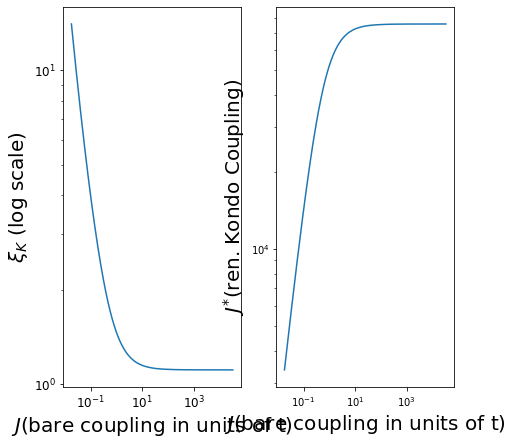

In [22]:
figure,ax=plt.subplots(1,2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.rcParams['figure.figsize'] = [14,7]
ax[0].plot(J0arr,1/(LambdaFParr[0]/Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$J$(bare coupling in units of t)',fontsize=20)
ax[0].set_ylabel(r'$\xi_{K}~$(log scale)',fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(J0arr,JfixedArr[0]*N*N,label='URG')
#ax[1].plot(J0arr[0:820],JfixedArr[0:820]*N*N,label='URG')
#plt.rcParams['figure.figsize'] = [14,7]
ax[1].set_xlabel(r'$J$(bare coupling in units of t)',fontsize=20)
ax[1].set_ylabel(r'$J^{*}$(ren. Kondo Coupling)',fontsize=20)
#ax.set_yticks(np.arange(1,7, 1.0))
plt.savefig('KondoComplete.svg')

In [23]:
# J0arr

In [24]:
# Lambda0/LambdaFParr[0][35:]

In [25]:
J=np.zeros(steps)
J_0=20
J[0]=J_0/(N*N)
k=0
for i in range(len(lambdaF)-1):
    Ek=(EFwvfAvg[i]-E_F)
    if(Ek-J[0]/4>0):
        if(Ek-J[i]/4.>0):
            J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
        else:
            Jfixed=4*Ek
            k=i
            J[i:]=4*Ek
            break
    else:
        if(Ek-J[i]/4<0):
            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            Jfixed=4*Ek
            k=i
            J[i:]=4*Ek
            break       
        

In [26]:
J[k]

7.395540760965581

In [27]:
Jfixed,k

(7.395540760965581, 173)

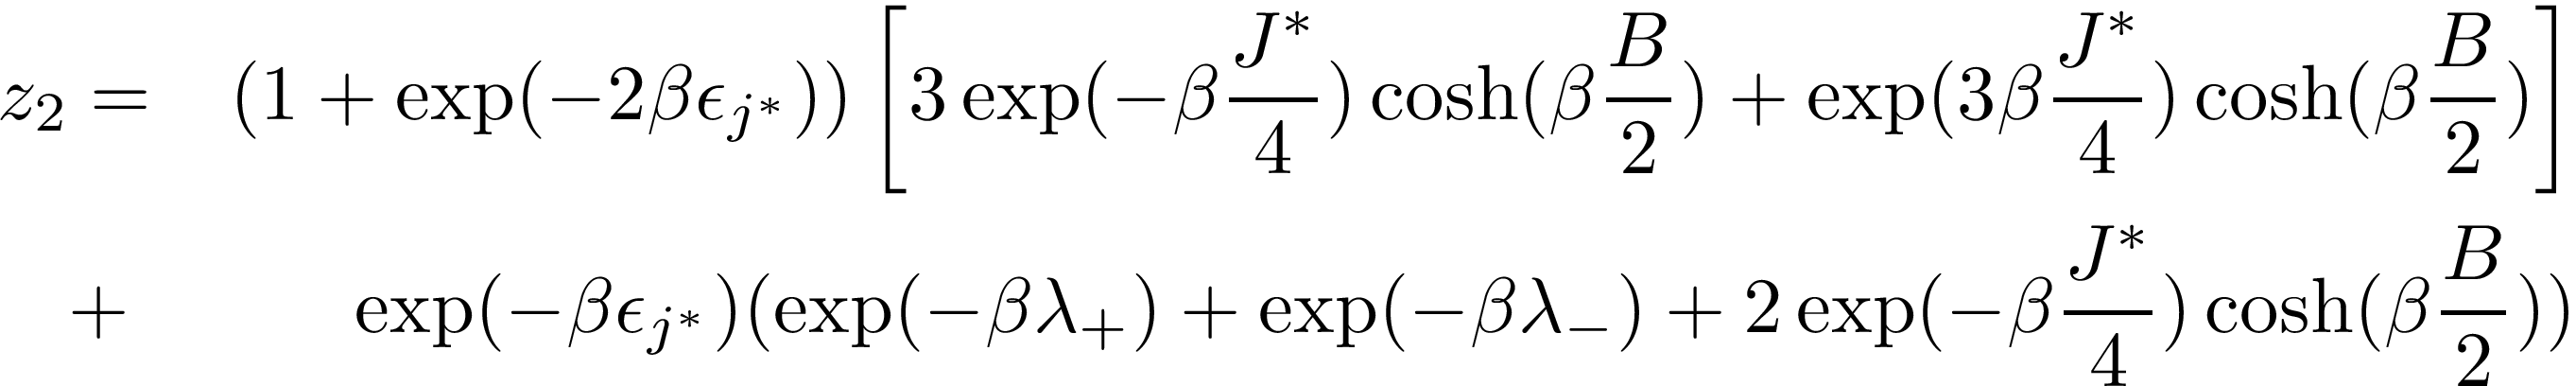

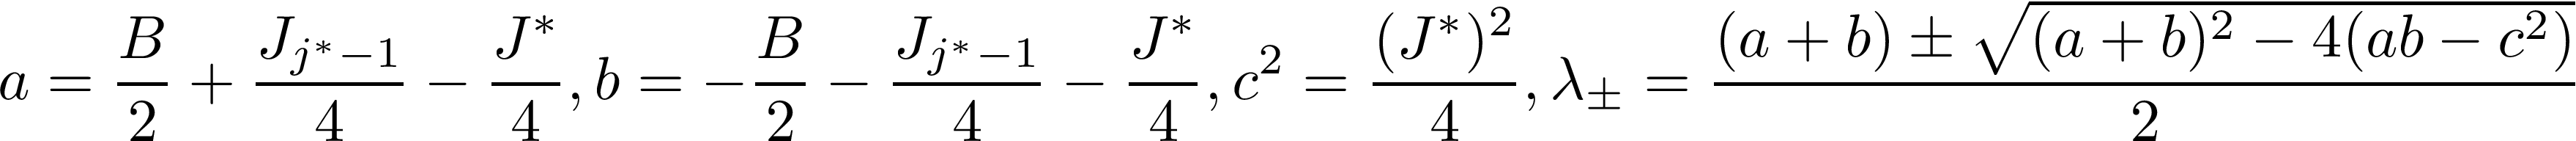

In [28]:
'''
B=np.linspace(1e-5,1e-2,3000)#magnetic field
Temp=np.linspace(1e-2,1,10000)#in kelvin
Jstar=Jfixed#magnitude of Kondo coupling at IR fixed point
Ekstar=EFwvfAvg[k]-E_F#magnitude of the dispersion for the boundary shell of the Kondo cloud
Bmesh,Tmesh=np.meshgrid(B,Temp)
kB=1
a=Bmesh/2.-Jstar/4#B/2.+J[k-2]/4-Jstar/4
b=-Bmesh/2.-Jstar/4#-B/2.-J[k-2]/4-Jstar/4#net magnitude of the polarizing field emerging from external magnetic field and the decoupled local Fermi liquid
c=Jstar/2.
E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))
'''
B=np.linspace(1e-3,2e-3,50)
Temp=np.linspace(0.008,20,10000)#np.linspace(0.008,5,10000)
kB=1
Jstar=Jfixed
Bmesh,Tmesh=np.meshgrid(B,Temp)
a=Bmesh/2.+J[k-20]/4-Jstar/4.
b=-Bmesh/2.-J[k-20]/4-Jstar/4.
c=Jfixed/2.
E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))

In [29]:
Tk=(EFwvfAvg-E_F).max()*lambdaF[k]/Lambda0

In [30]:
Tk

1.8596109545698407

In [31]:
Z=np.exp(-E1/(kB*Tmesh))+np.exp(-E2/(kB*Tmesh))+2*np.exp(-(Jstar/4)/(kB*Tmesh))*np.cosh(Bmesh/(2*kB*Tmesh))

In [32]:
magnetization=kB*Tmesh*(np.gradient(Z,B,axis=1)/Z)

In [33]:
susceptibility=np.gradient(magnetization,B,axis=1)

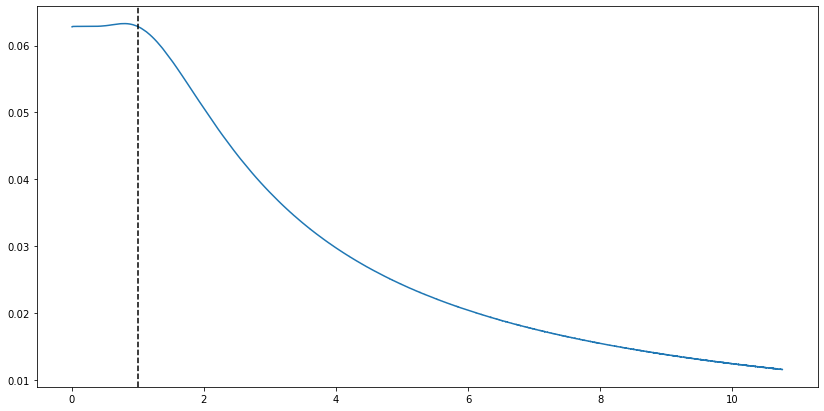

In [34]:
figure,ax=plt.subplots(1)
plt.rcParams['figure.figsize'] = [7,7]
#ax.set_yscale('log')
#ax.plot(Temp/Tk,magnetization[:,0])
ax.plot(Temp/Tk,(susceptibility[:,0]*Tk))
ax.axvline(x=1,linestyle='--',color='k')

In [35]:
#Computing Specific heat

In [36]:
b=(2-0.2)/10000
(4-0.2)*(1/b)

21111.11111111111

In [37]:
#Temp=np.linspace(0.2,4,20000)
Temp=np.linspace(0.0005,5,40000)#np.linspace(0.0005,5,20000)#np.linspace(0.0005,5,900000)
a=+J[k-20]/4-Jstar/4.
b=-J[k-20]/4-Jstar/4.
c=Jfixed/2.
Ekstar=EFwvfAvg[k]-E_F
E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))
Z=(np.exp(-E1/(kB*Temp))+np.exp(-E2/(kB*Temp))+2*np.exp(-(Jstar/4)/(kB*Temp)))#np.exp(-Ekstar/(kB*Temp))*(np.exp(-E1/(kB*Temp))+np.exp(-E2/(kB*Temp))+2*np.exp(-(Jstar/4)/(kB*Temp)))
#+(1+np.exp(-2*Ekstar/(kB*Temp)))*(3*np.exp(-(Jstar/4)/(kB*Temp))+np.exp(-(3*Jstar/4.)/(kB*Temp)))#partition function at zero magnetic field

In [38]:
Z_0=np.exp(-(EFwvfAvg[k]-E_F)/(kB*Temp))+1+np.exp(-2*(EFwvfAvg[k]-E_F)/(kB*Temp))

In [39]:
C0=np.gradient(Temp*Temp*np.gradient(np.log(Z_0),Temp),Temp)

In [40]:
# C0

In [41]:
C=np.gradient(Temp*Temp*np.gradient(np.log(Z),Temp),Temp)

In [42]:
# [print(C[i]) for i in range(len(C))]

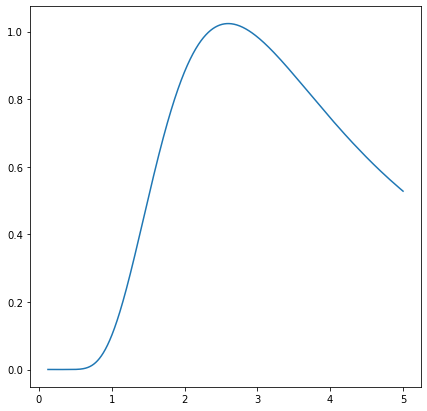

In [43]:
plt.plot(Temp[1000:-2],C[1000:-2])

In [ ]:
# C

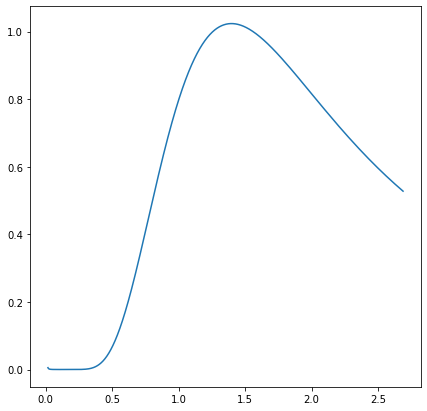

In [84]:
#plt.plot(Temp[3:-2]/Tk,C0[3:-2])
plt.plot(Temp[250:-2]/Tk,C[250:-2])

In [85]:
#Computing Wilson's ratio
B=np.linspace(1e-3,2e-3,50)
Temp=np.linspace(0.0005,5,40000)
kB=1
Jstar=Jfixed
Bmesh,Tmesh=np.meshgrid(B,Temp)
a=Bmesh/2.+J[k-20]/4-Jstar/4.
b=-Bmesh/2.-J[k-20]/4-Jstar/4.
c=Jstar/2.
E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))
Z=np.exp(-E1/(kB*Tmesh))+np.exp(-E2/(kB*Tmesh))+2*np.exp(-(Jstar/4)/(kB*Tmesh))*np.cosh(Bmesh/(2*kB*Tmesh))
magnetization=kB*Tmesh*(np.gradient(Z,B,axis=1)/Z)
Chi=np.gradient(magnetization,B,axis=1)[:,0]


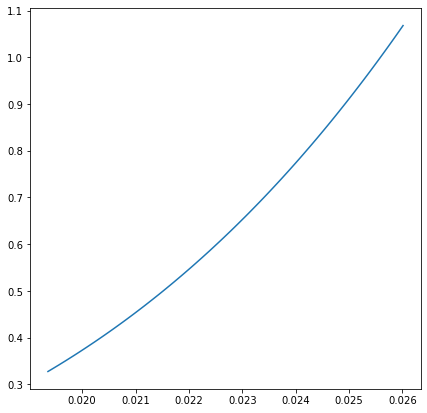

In [86]:
figure,ax=plt.subplots()
#ax.set_yscale('log')
R=(Temp[4:-2][280:-2]*Chi[4:-2][280:-2])/(C[4:-2][280:-2])

plt.plot((Temp[4:-2][280:-2]/Tk)[0:100],R[0:100])

In [ ]:
R

In [ ]:
R

$H=J\mathbf{S}\cdot\mathbf{s}+BS^{z}$

In [ ]:
J=Jstar
B=np.linspace(5e-5,1e-1,5000)
Temp=np.linspace(8e-3,1,10000)
kB=1
Bmesh,Tmesh=np.meshgrid(B,Temp)
a=Bmesh/2.-J/4.
b=-Bmesh/2.-J/4.
c=J/2.
E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))
Bmesh,Tmesh=np.meshgrid(B,Temp)
#cosTheta=Bmesh/np.sqrt(Bmesh**2+J**2/4.)
#ExpSz1=cosTheta
#ExpSz2=-cosTheta

In [ ]:
Z=2*np.exp((-J/4.)/(kB*Tmesh))*np.cosh(Bmesh/(2*kB*Tmesh))+np.exp(-E1/(kB*Tmesh))+np.exp(-E2/(kB*Tmesh))

In [ ]:
Z.shape

In [ ]:
magnetization=kB*Tmesh*(np.gradient(Z,axis=1)/Z)
susceptibility=np.gradient(magnetization,axis=1)

In [ ]:
plt.plot(Temp,susceptibility[:,0])

In [ ]:
Temp=np.linspace(2.9e-2,5000,100000)
kB=1
beta=1/(kB*Temp)
Jstar=Jfixed
J1=0#Jstar/2.
Ekstar=EFwvfAvg[k]-E_F
#Z_0=2*np.exp(-beta*Ekstar)*2*np.exp(-beta*Jstar/4.)*(np.cosh(beta*J1/2.)+np.cosh((beta/2)*np.sqrt(J1**2/4.+Jstar)))+(1+np.exp(-2*beta*Ekstar))*2*np.exp(-beta*Jstar/4.)*(1+np.cosh((beta/2.)*Jstar))
#dZ_dB=np.exp(-beta*Ekstar)*np.exp(-beta*Jstar/4.)*beta*(np.sinh(beta*J1/2.)+(J1/(np.sqrt(J1**2+Jstar**2)))*np.sinh((beta/2.)*np.sqrt(J1**2+Jstar**2)))
#d2Z_dB2=(1+np.exp(-2*beta*Ekstar))*np.exp(-beta*Jstar/4.)*(beta/2.+(1/Jstar)*np.sinh(beta*Jstar/2.))+np.exp(-beta*Ekstar)*np.exp(-beta*Jstar/4.)*((beta/2.)*np.cosh(beta*Jstar/2.)+(1/np.sqrt(J1**2+Jstar**2))*np.sinh((beta/2.)*np.sqrt(J1**2+Jstar**2))+(beta/2.)*(J1**2/(J1**2+Jstar**2))*np.cosh((beta/2.)*np.sqrt(J1**2+Jstar**2))-(J1**2/(J1**2+Jstar**2)**(3/2.))*np.sinh((beta/2.)*np.sqrt(J1**2+Jstar**2)))                                              

In [ ]:
Chi=(1/(4*kB*Temp)+(1/(2*Jstar))*np.sinh(Jstar/(2*kB*Temp)))/(1+np.cosh(Jstar/(2*kB*Temp)))

In [ ]:
figure,ax=plt.subplots(1)
ax.set_xscale('log')
ax.plot(Temp/Tk,Chi*Temp)
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
Temp=np.linspace(2.9e-2,20,100)
kB=1
beta=1/(kB*Temp)
Jstar=Jfixed
J1=0#Jstar/2.
Ekstar=EFwvfAvg[k]-E_F
Chi=(1/(4*kB*Temp)+(1/(2*Jstar))*np.sinh(Jstar/(2*kB*Temp)))/(1+np.cosh(Jstar/(2*kB*Temp)))
figure,ax=plt.subplots(1)
#ax.set_xscale('log')
ax.plot(Temp/Tk,1/(Chi*Tk))
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
figure,ax=plt.subplots(1)
ax.set_xscale('log')
ax.plot(Temp/Tk,Chi*Tk)
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
Chi[0]*Tk/(0.413/4)

In [ ]:
Temp=np.linspace(2.9e-2,20,10000)
kB=1
beta=1/(kB*Temp)
Chi=(1/(4*kB*Temp)+(1/(2*Jstar))*np.sinh(Jstar/(2*kB*Temp)))/(1+np.cosh(Jstar/(2*kB*Temp)))
Jstar=Jfixed
J1=0#Jstar/2.
Ekstar=EFwvfAvg[k]-E_F
figure,ax=plt.subplots(1)
ax.plot(Temp/Tk,1/(Chi*Tk))
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
Chi*Temp

In [ ]:
2*np.exp(Jstar/(4*kB*T))*(np.cosh(B[j]/(2*kB*T))+np.cosh(np.sqrt(B[j]**2+Jstar**2)/(2*kB*T)))

$E_{1}=\frac{1}{2}(-\frac{J}{2}+\sqrt{B^{2}+J^{2}})$, $E_{2}=\frac{1}{2}(-\frac{J}{2}-\sqrt{B^{2}+J^{2}})$<br>
$Z(B)=2\exp(\beta\frac{J}{4})\left[\cosh(\beta\frac{B}{2})+\cosh(\frac{\beta}{2}(\sqrt{B^{2}+J^{2}}))\right]$<br>
$\bar{Z}(B)=2\exp(-\beta\epsilon^{*})Z(B+J^{*})+(1+\exp(-2\beta\epsilon^{*}))Z(B)$<br>
$\frac{d\bar{Z}(B)}{dB}=(1+\exp(-2\beta\epsilon^{*}))\exp(\beta\frac{J}{4})\beta\left[\sinh(\beta\frac{B}{2})
+\frac{B}{\sqrt{B^{2}+J^{2}}}\sinh(\frac{\beta}{2}\sqrt{B^{2}+J^{2}})\right]$<br>
$+\exp(-\beta\epsilon^{*})\exp(-\beta\frac{J}{4})\beta\left[\sinh(\beta\frac{B+J^{*}}{2})+\frac{B+J^{*}}{\sqrt{(B+J^{*})^{2}+J^{2}}}\sinh(\frac{\beta}{2}\sqrt{(B+J^{*})^{2}+J^{2}})\right]$<br>
$M=\frac{k_{B}T}{Z(B)}\frac{dZ(B)}{dB}$<br>
<br>
$\frac{dM}{dB}=-\frac{k_{B}T}{(Z(B))^{2}}\left(\frac{dZ(B)}{dB}\right)^{2}+\frac{k_{B}T}{Z(B)}\frac{d^{2}Z(B)}{dB^{2}}$<br>
<br>
$\lim_{B\to 0}k_{B}T\frac{d^{2}Z(B)}{dB^{2}}=(1+\exp(-2\beta\epsilon^{*}))\exp(\beta\frac{J}{4})\left[\frac{\beta}{2}+\frac{1}{J}\sinh(\frac{\beta}{2}J)\right]$<br>
$+\exp(-\beta\epsilon^{*})\exp(\beta\frac{J}{4})\left[\frac{\beta}{2}\cosh(\beta\frac{J^{*}}{2})+\frac{1}{\sqrt{(J^{*})^{2}+J^{2}}}\sinh(\frac{\beta}{2}\sqrt{(J^{*})^{2}+J^{2}})-\frac{(J^{*})^{2}}{((J^{*})^{2}+J^{2})^{3/2}}\sinh(\frac{\beta}{2}\sqrt{(J^{*})^{2}+J^{2}})+\frac{\beta}{2}\frac{(J^{*})^{2}}{(J^{*})^{2}+J^{2}}\cosh(\frac{\beta}{2}\sqrt{(J^{*})^{2}+J^{2}})\right]$<br>

$\lim_{B\to 0}\frac{dM}{dB}=\frac{(\frac{\beta}{4}+\frac{1}{2J}\sinh(\frac{\beta}{2}J))(1+\cosh(\frac{\beta}{2}J))}{(1+\cosh(\frac{\beta}{2}J))^{2}}-\frac{\beta}{4}\frac{1}{(1+\cosh(\frac{\beta}{2}J))^{2}}$<br>
$=\frac{\frac{\beta}{4}\cosh(\frac{\beta}{2}J)+\frac{1}{2J}\sinh(\frac{\beta}{2}J)(1+\cosh(\frac{\beta}{2}J))}{(1+\cosh(\frac{\beta}{2}J))^{2}}$

In [ ]:
Temp=np.linspace(2.9e-2,10000,100000)#np.linspace(2.39e-2,20,10000)
Chi1=np.zeros(len(Temp),dtype='int64')
Chi2=np.zeros(len(Temp),dtype='int64')
kB=1
Jstar=Jfixed

In [ ]:
Jstar

In [ ]:
Chi1=(1/(4*kB*Temp))*np.cosh(Jstar/(2*kB*Temp))+(1/(2*Jstar))*np.sinh(Jstar/(2*kB*Temp))*(1+np.cosh(Jstar/(2*kB*Temp)))
Chi2=(1+np.cosh(Jstar/(2*kB*Temp)))**2
Chi=Chi1/Chi2+(1/Chi2)*(1/(4*Temp))

In [ ]:
figure,ax=plt.subplots()
ax.set_xscale('log')
ax.plot(Temp/Tk,Chi*Temp)
#plt.xlim([0,5])
#plt.ylim([0,0.20])

$Z=2\exp(\beta\frac{J}{4})\left[1+\cosh(\frac{\beta}{2}J)\right]=\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})$<br>
$\frac{dZ}{dT}=-\frac{3J}{4k_{B}T^{2}}\exp(\frac{3J}{4 k_{B}T})+\frac{3J}{4k_{B}T^{2}}\exp(-\frac{J}{4 k_{B}T})$<br>
$\frac{d^{2}Z}{dT^{2}}=\frac{6J}{4k_{B}T^{3}}\exp(\frac{3J}{4 k_{B}T})+\frac{9J^{2}}{16k^{2}_{B}T^{4}}\exp(\frac{3J}{4 k_{B}T})-\frac{6J}{4k_{B}T^{3}}\exp(-\frac{J}{4 k_{B}T})+\frac{3J^{2}}{16k^{2}_{B}T^{4}}\exp(-\frac{J}{4 k_{B}T})$<br>

$\frac{k_{B}T^{2}}{Z}\frac{d^{2}Z}{dT^{2}}=\frac{3J}{2T}\frac{\exp(\frac{3J}{4 k_{B}T})-\exp(-\frac{J}{4 k_{B}T})}{\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}+\frac{J^{2}}{16k_{B}T^{2}}\frac{9\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}{\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}$<br>

$\frac{2k_{B}T}{Z}\frac{dZ}{dT}=-\frac{3J}{2T}\frac{\exp(\frac{3J}{4 k_{B}T})-\exp(-\frac{J}{4 k_{B}T})}{\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}$<br>

$-\frac{k_{B}T^{2}}{Z^{2}}\left(\frac{dZ}{dT}\right)^{2}=-\frac{9J^{2}}{16k_{B}T^{2}}\frac{(\exp(-\frac{J}{4 k_{B}T})-\exp(\frac{3J}{4 k_{B}T}))^{2}}{(\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T}))^{2}}$

$C=\frac{d}{dT}(k_{B}T^{2}\frac{1}{Z}\frac{dZ}{dT})=-\frac{k_{B}T^{2}}{Z^{2}}\left(\frac{dZ}{dT}\right)^{2}+\frac{2k_{B}T}{Z}\frac{dZ}{dT}+\frac{k_{B}T^{2}}{Z}\frac{d^{2}Z}{dT^{2}}$<br>

$C=\frac{J^{2}}{16k_{B}T^{2}}\frac{9\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}{\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T})}-\frac{9J^{2}}{16k_{B}T^{2}}\frac{(\exp(-\frac{J}{4 k_{B}T})-\exp(\frac{3J}{4 k_{B}T}))^{2}}{(\exp(\frac{3J}{4 k_{B}T})+3\exp(-\frac{J}{4 k_{B}T}))^{2}}$

In [ ]:
Temp=np.linspace(2.9e-2,1000,100000)
boltz1=np.exp(3*Jstar/(4*kB*Temp))
boltz2=np.exp(-Jstar/(4*kB*Temp))
scale=Jstar**2/(16*kB*Temp**2)

In [ ]:
boltz2

In [ ]:
scale

In [ ]:
C=scale*(9*boltz1+3*boltz2)/(boltz1+3*boltz2)-9*scale*((boltz1-boltz2)/(boltz1+3*boltz2))**2

In [ ]:
C

In [ ]:
figure,ax=plt.subplots()
ax.set_xscale('log')
ax.plot((Temp/Tk),C)
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
figure,ax=plt.subplots()
ax.set_xscale('log')
ax.plot((Temp/Tk),(C/Temp)*Tk)
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
figure,ax=plt.subplots()
ax.plot((Temp/Tk)[2078:],(1/(C/(Temp*Chi))[2078:])*(4*np.pi**2/3))
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
(1/(C/(Temp*Chi))[2078:])*(4*np.pi**2/3)>2

In [ ]:
np.where(Temp/Tk>1)

In [ ]:
C

$H^{*}_{K}=J^{*}\mathbf{S}\cdot\mathbf{s}+\sum_{l=N,m=1}^{j^{*},n_{l}}J_{l}S^{z}s^{z}_{l,m}
+\sum_{l=N,m=1}^{j^{*},n_{l}}\epsilon_{l}(\hat{n}_{l,m,\uparrow}+\hat{n}_{l,m,\downarrow})$<br>
$\exp(-\beta H^{*}_{K})=\prod_{l=N,m=1}^{j^{*},n_{l}}\exp(-\beta\epsilon_{l}(\hat{n}_{l,m,\uparrow}+\hat{n}_{l,m,\downarrow}))\times\exp(-\beta(J^{*}\mathbf{S}\cdot\mathbf{s}+\sum_{l=N,m=1}^{j^{*},n_{l}}J_{l}S^{z}s^{z}_{l,m}))$<br>

$\begin{pmatrix}-\frac{J^{*}}{4}+\sum_{l=N,m=1}^{j^{*},n_{l}}\frac{J_{l}}{2}s^{z}_{l,m} & \frac{J^{*}}{2}\\ 
\frac{J^{*}}{2} & -\frac{J^{*}}{4}-\sum_{l=N,m=1}^{j^{*},n_{l}}\frac{J_{l}}{2}s^{z}_{l,m}\end{pmatrix}=-\frac{J^{*}}{4}+\sigma^{z}h_{z}+\frac{J^{*}}{2}\sigma_{x}=-\frac{J^{*}}{4}+A\boldsymbol{\sigma}\cdot\mathbf{\hat{n}}, A=\sqrt{h^{2}_{z}+\frac{(J^{*})^{2}}{4}},\cos\theta=\frac{h_{z}}{\sqrt{h^{2}_{z}+\frac{(J^{*})^{2}}{4}}}$<br>
$\exp(-\beta(J^{*}\mathbf{S}\cdot\mathbf{s}+\sum_{l=N,m=1}^{j^{*},n_{l}}J_{l}S^{z}s^{z}_{l,m}))=2\exp(-\beta\frac{J^{*}}{4})\cosh\left(\sum_{l=N,m=1}^{j^{*},n_{l}}\frac{\beta J_{l}}{2}s^{z}_{l,m}\right)+\exp(\beta\frac{J^{*}}{4})\exp\left(-\beta A\mathbf{\sigma}\cdot\hat{\mathbf{n}}\right)=2\exp(-\beta\frac{J^{*}}{4})\cosh\left(\sum_{l=N,m=1}^{j^{*},n_{l}}\frac{\beta J_{l}}{2}s^{z}_{l,m}\right)+\exp(\beta\frac{J^{*}}{4})\left[\cosh(\beta A)+\boldsymbol{\sigma}\cdot\hat{n}\sinh(\beta A)\right]$<br>

$Tr_{imp+cloud}(\exp(-\beta(J^{*}\mathbf{S}\cdot\mathbf{s}+\sum_{l=N,m=1}^{j^{*},n_{l}}J_{l}S^{z}s^{z}_{l,m})))\approx \exp(\beta\frac{J^{*}}{4})\exp(\beta A)$<br>

$-k_{B}T\log(Tr_{imp+cloud}(\exp(-\beta H^{*}_{K}))\approx \sum_{l,m}\epsilon_{l}(\hat{n}_{l,m,\uparrow}+\hat{n}_{l,m,\downarrow})-\frac{J^{*}}{4}-\frac{J^{*}}{2}\sqrt{1+\frac{4h_{z}^{2}}{(J^{*})^{2}}}$<br>
$\sum_{l,m}\epsilon_{l}(\hat{n}_{l,m,\uparrow}+\hat{n}_{l,m,\downarrow})-\frac{3J^{*}}{4}-\frac{h^{2}_{z}}{J^{*}}$

### Effective Hamiltonian for the Local Fermi liquid at IR fixed point
$H_{LFL}=\sum_{l,m}\epsilon_{l}(\hat{n}_{l,m,\uparrow}+\hat{n}_{l,m,\downarrow})-\sum_{l,l',m,m'}f_{ll'}s^{z}_{l,m}s^{z}_{l,m'}, f_{ll'}=\frac{J_{l}J_{l'}}{J^{*}}, s^{z}_{l,m}=\frac{1}{2}(\hat{n}_{l,m,\uparrow}-\hat{n}_{l,m,\downarrow})$

$\frac{\delta\mathcal{E}}{\delta n_{l,m,\sigma}}=\epsilon_{l}+\sum_{l',m'}\frac{J_{l}J_{l'}}{J^{*}}\delta n_{l',m',-\sigma}$, $~~~~~~~\delta n_{l',m',-\sigma}=\frac{\partial f(\epsilon_{l'})}{\partial T}dT$

$H_{1-LFL}=\sum_{l,m,\sigma}(\epsilon_{l}+\Sigma_{\sigma,l}+\sigma B )\hat{n}_{l,m,\sigma}$

In [ ]:
lambdaF=Lambda0*eps**np.linspace(0,steps-1,steps)
ThetaF,LambdaF=np.meshgrid(thetaF0,lambdaF)
Fwvfx_out = coordsFx_irr+LambdaF*np.cos(ThetaF)
Fwvfy_out = coordsFy_irr+LambdaF*np.sin(ThetaF)
EFwvf=-2*(np.cos(Fwvfx_out)+np.cos(Fwvfy_out))
#dispersion of electronic states residing outside the Fermi energy
EFwvfAvg=np.sum(EFwvf,axis=1)/len(thetaF0)

In [ ]:
plt.plot(np.log(lambdaF/Lambda0),EFwvfAvg-E_F)

In [ ]:
EFwvfAvg-E_F

In [ ]:
Temp=np.linspace(2.9e-2,20,5000)

In [ ]:
Temp[1]-Temp[0]

In [ ]:
ELambdaGrid,TempGrid=np.meshgrid(EFwvfAvg[0:k+1],Temp)

In [ ]:
plt.plot(np.log(lambdaF[0:k+1]/Lambda0),EFwvfAvg[0:k+1]-E_F)

In [ ]:
FDdistGrid=(1+np.exp(-ELambdaGrid/(TempGrid)))

In [ ]:
dFDdist_DT=np.gradient(FDdistGrid,Temp,axis=0)

In [ ]:
#quasi particle density for states residing outside Fermi energy 
delta_n = dFDdist_DT[0]*(Temp[1]-Temp[0])

In [ ]:
# Kondo coupling
J_LFL=J[0:k+1]

In [ ]:
plt.plot(np.log(lambdaF[0:k+1]/Lambda0),J_LFL)

In [ ]:
#computing the 1-p self energy
Sigma=np.zeros(k+1)*0.0
for l in range(k+1):
    Sigma[l]=(J_LFL[l]*(np.sum(J_LFL*delta_n)-(J_LFL[l]*delta_n[l])))/(J_LFL[k])

In [ ]:
figure,ax=plt.subplots(1)
plt.plot(np.log(lambdaF[0:k+1]/Lambda0),np.log(Sigma))

In [ ]:
#computing the renormalized quasiparticle energies
B=np.linspace(1e-3,2e-3,10)
Ekbare=(EFwvfAvg-E_F)[0:k+1]
Bmesh,Ekmesh=np.meshgrid(B,Ekbare)
Bmesh,SigmaMesh=np.meshgrid(B,Sigma)
EkrenUp=Ekmesh+SigmaMesh+Bmesh 
EkrenDown=Ekmesh-SigmaMesh-Bmesh

In [ ]:
EkrenUp.shape

In [ ]:
#computing Free energy function
Z=np.zeros([len(Temp),len(B)])
Z.shape
Bgrid,TempGrid=np.meshgrid(B,Temp)  

In [ ]:
EkrenUp[0],Ekbare[0]

In [ ]:
#B=np.linspace(1e-3,2e-3,50)
#Temp=np.linspace(0.008,20,10000)#np.linspace(0.008,5,10000)
kB=1
Jstar=Jfixed
#Bmesh,Tmesh=np.meshgrid(B,Temp)
Temp=np.linspace(1e-1,20,5000)#np.linspace(2.9e-2,20,5000)
#a=Bmesh/2.+J[k-20]/4-Jstar/4.
#b=-Bmesh/2.-J[k-20]/4-Jstar/4.
#c=Jfixed/2.
#E1=0.5*(a+b+np.sqrt((a-b)**2+4*c**2))
#E2=0.5*(a+b-np.sqrt((a-b)**2+4*c**2))
#Z=(np.exp(-E1/(kB*Temp))+np.exp(-E2/(kB*Temp))+2*np.exp(-(Jstar/4)/(kB*Temp)))
for i in range(len(Temp)):
    T=Temp[i]
    for j in range(len(B)):
        EkrenUp=Sigma+B[j]
        EkrenDown=Sigma-B[j]
        Z1=2*np.exp(Jstar/(4*kB*T))*(np.cosh(B[j]/(2*kB*T))+np.cosh(np.sqrt(B[j]**2+Jstar**2)/(2*kB*T)))
        Z[i][j]=np.log(Z1)#np.log(1+np.exp(-EkrenUp[k]/(kB*T)))+np.log(1+np.exp(-EkrenDown[k]/(kB*T)))+np.log(Z1)#2*np.pi*np.sqrt(0.2)*(np.log(np.exp(-(EkrenUp[k])/(T))+1)+np.log((np.exp(-(EkrenDown[k])/(T))+1)))#+np.log(Z)

In [ ]:
M=(np.gradient(Z,B,axis=1))*TempGrid
Chi=np.gradient(Z,B,axis=1)

In [ ]:
Chi[:,0].shape

In [ ]:
figure,ax=plt.subplots(1)
ax.plot(Temp,Chi[:,0])
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
#Free energy at zero magnetic field
F0=np.zeros(len(Temp))
for i in range(len(Temp)):
    T=Temp[i]
    Ekren=Ekbare+Sigma
    F0[i]=2*np.sum(np.log(np.exp(-Ekren/(T))+1))

In [ ]:
C=np.gradient(np.gradient(F0,T)*Temp*Temp,Temp)

In [ ]:
figure,ax=plt.subplots(1)
ax.plot(Temp/Tk,C)
ax.axvline(x=1,linestyle='--',color='k')

In [ ]:
Tk=4.178

In [ ]:
EFwvfAvg-E_F

In [ ]:
Tk

In [ ]:
Temp=np.linspace(0.001,5000,3000)
Chi=np.zeros(len(Temp))*0.0
factor=25#25
Tkondo=Tk*factor*0.1
Ek=np.linspace(-4,4,45500)*factor
FD=np.zeros(100)
print(Tkondo)
for i in range(len(Temp)):
    T=Temp[i]
    FD=1/(np.exp(Ek/T)+1)
    Chi[i]=(2/Tkondo)*np.sum(-(1/(np.pi))*(FD*((Ek/T)/(((Ek/T)**2+1)**2))*((Ek[1]-Ek[0])/T)))

In [ ]:
figure,ax=plt.subplots(1)
ax.set_xscale('log')
ax.plot(Temp/Tkondo,Chi*Tkondo)
ax.axvline(x=1,linestyle='--',color='k')

$f=\frac{1}{\exp(\omega)+1}, \omega=\frac{\epsilon}{k_{B}T}$, $\frac{df}{d\omega}=-\frac{\exp(\omega)}{(1+\exp(\omega))^{2}}$, $\frac{d^{2}f}{d\omega^{2}}=-\frac{\exp(\omega)}{(1+\exp(\omega))^{2}}+2\frac{\exp(2\omega)}{(1+\exp(\omega))^{3}}$,<br>
$d\omega = -\frac{\omega}{T}dT$ , $\frac{d}{dT}=-\frac{\omega}{T}\frac{d}{d\omega}$, $\frac{d^{2}}{dT^{2}}=\frac{\omega^{2}}{T^{2}}\frac{d}{d\omega}+\frac{\omega}{T^{2}}\frac{d}{d\omega}+\frac{\omega^{2}}{T^{2}}\frac{d^{2}}{d\omega^{2}}$ <br>
$\frac{d^{2}f}{dT^{2}}=\frac{\omega^{2}}{T^{2}}\frac{df}{d\omega}+\frac{\omega}{T^{2}}\frac{df}{d\omega}+\frac{\omega^{2}}{T^{2}}\frac{d^{2}f}{d\omega^{2}}=-2\frac{\omega^{2}}{T^{2}}\frac{\exp(\omega)}{1+\exp(\omega)}f-\frac{\omega}{T^{2}}\frac{\exp(\omega)}{(1+\exp(\omega))^{2}}+\frac{2\omega^{2}}{T^{2}}\frac{\exp(2\omega)}{(1+\exp(\omega))^{3}}$<br>

In [ ]:
Temp=np.linspace(0.02,10,1000)
gamma=np.zeros(len(Temp))*0.0
factor=1#25
Tkondo=(Tk)*factor
Ek=np.linspace(-4,4,1000)*factor

print(Tkondo)
for i in range(1):
    T=Temp[i+1]
    omega=Ek/T
    FD_T2=-2*((omega*omega)/T**2-omega/T**2)*(np.exp(omega)/((1+np.exp(omega))*(1+np.exp(omega))))+2*((omega*omega)/T**2)*np.exp(2*omega)/((1+np.exp(omega))*(1+np.exp(omega))*(1+np.exp(omega)))   
    arctan=np.arctan(1/omega)
#plt.plot(Temp,FD_T2)
plt.plot(Temp,FD_T2*arctan)

In [ ]:
plt.plot(gamma)